## Fine-tune LayoutLMv2 Document Question Answering on the DocVQA dataset

## Document Question Answering

Document Question Answering, also referred to as Document Visual Question Answering, is a task that involves providing answers to questions posed about document images. The input to models supporting this task is typically a combination of an image and a question, and the output is an answer expressed in natural language. These models utilize multiple modalities, including text, the positions of words (bounding boxes), and the image itself.

## LayoutLMv2

LayoutLMv2 solves the document question-answering task by adding a question-answering head on top of the final hidden states of the tokens, to predict the positions of the start and end tokens of the answer. In other words, the problem is treated as extractive question answering: given the context, extract which piece of information answers the question. The context comes from the output of an OCR engine, here it is Google’s Tesseract.

## Setup

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
# Login to huggingface hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install -q transformers datasets
!pip install "git+https://github.com/facebookresearch/detectron2.git"
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-s1ssngf5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-s1ssng

In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,853 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Define Global Variables

In [ ]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 4

## Load the small sample of preprocessed DocVQA dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nielsr/docvqa_1200_examples")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

(…)-00000-of-00001-f795527aa19f0f90.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00001-41a63b2e1b4ecc5e.parquet:   0%|          | 0.00/25.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 200
    })
})

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'query': {'de': Value(dtype='string', id=None),
  'en': Value(dtype='string', id=None),
  'es': Value(dtype='string', id=None),
  'fr': Value(dtype='string', id=None),
  'it': Value(dtype='string', id=None)},
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), length=-1, id=None),
 'answer': {'match_score': Value(dtype='float64', id=None),
  'matched_text': Value(dtype='string', id=None),
  'start': Value(dtype='int64', id=None),
  'text': Value(dtype='string', id=None)}}

* `id`: the example's id
* `image`: a PIL.Image.Image object containing the document image
* `query`: the question string - natural language asked question, in several languages
* `answers`: a list of correct answers provided by human annotators
* `words` and `bounding_boxes`: the results of OCR, which we will not use here
* `answer`: an answer matched by a different model which we will not use here

In [ ]:
# Let’s leave only English questions, and drop the answer feature
updated_dataset = dataset.map(lambda example: {"question": example["query"]["en"]}, remove_columns=["query"])
updated_dataset = updated_dataset.map(
    lambda example: {"answer": example["answers"][0]}, remove_columns=["answer", "answers"]
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Remove examples where the embedding longer than 512
updated_dataset = updated_dataset.filter(lambda x: len(x["words"]) + len(x["question"].split()) < 512)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Remove the OCR features from this dataset
updated_dataset = updated_dataset.remove_columns("words")
updated_dataset = updated_dataset.remove_columns("bounding_boxes")

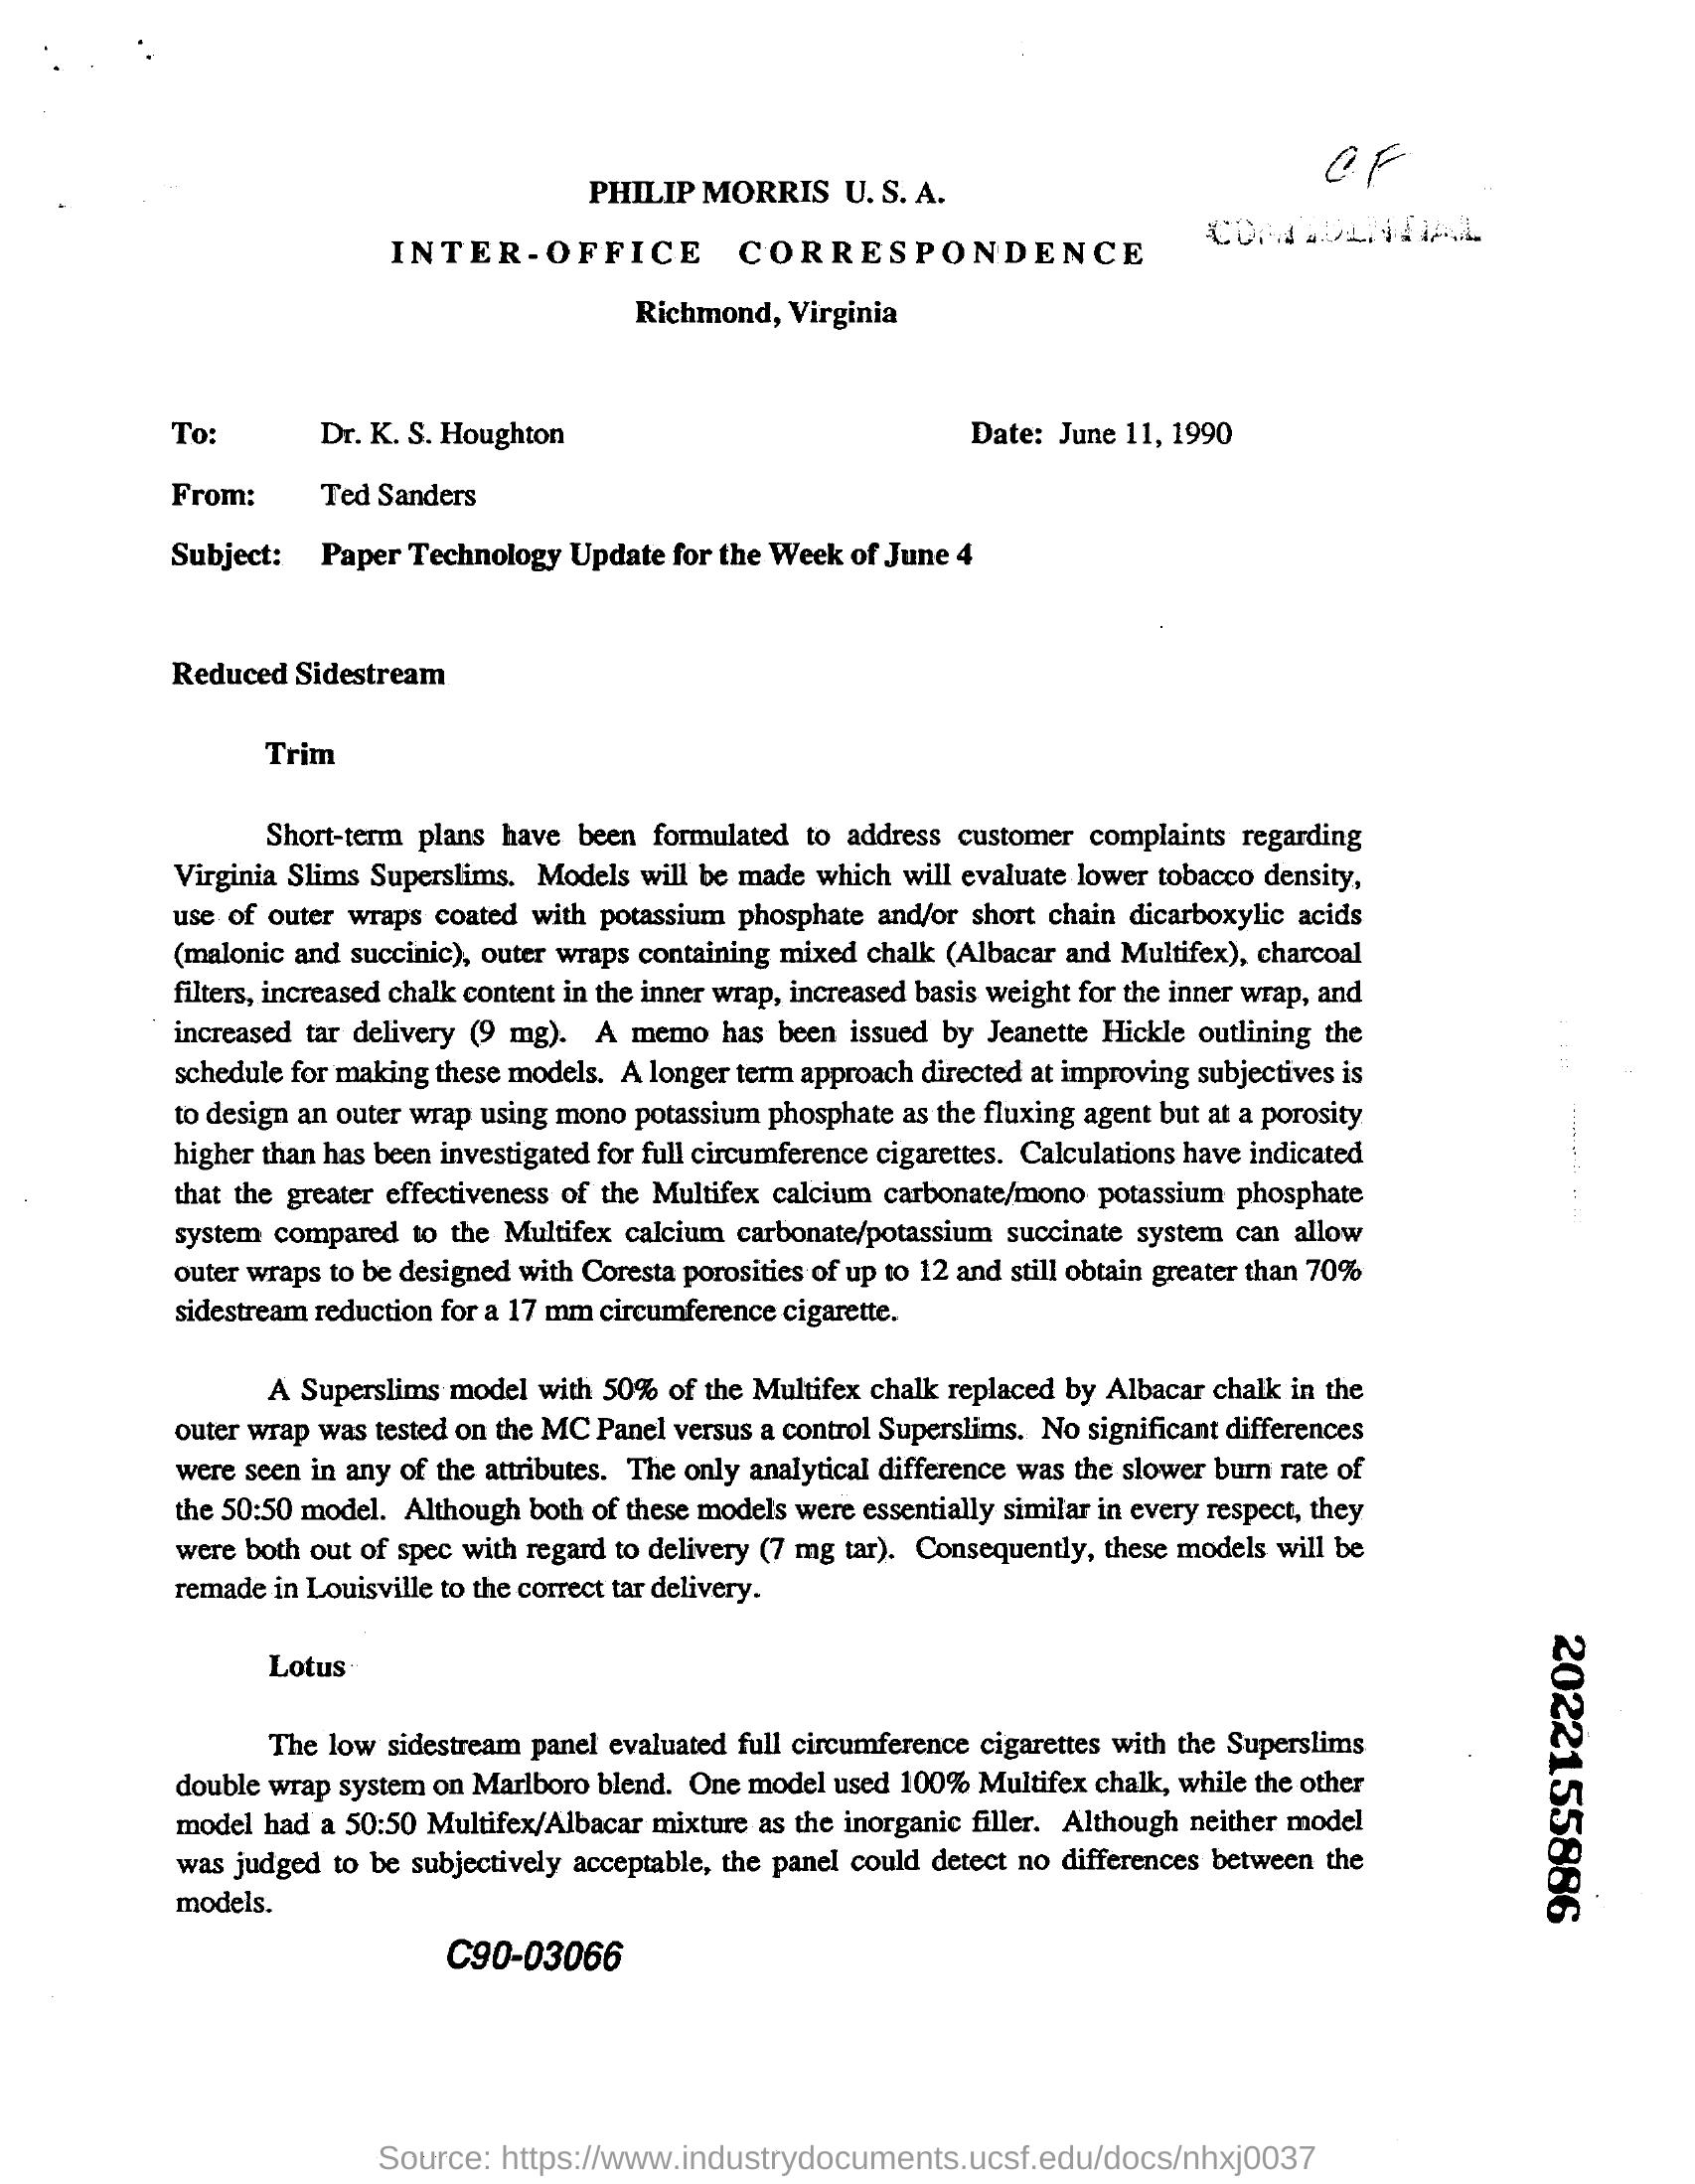

In [ ]:
# Visualize an example
updated_dataset["train"][7]["image"]

## Preprocess the data

In [ ]:
# load the LayoutLMv2Processor
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Preprocessing document images

In [ ]:
# define a function to prepare the document images for the model
image_processor = processor.image_processor

def get_ocr_words_and_boxes(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    encoded_inputs = image_processor(images)

    examples["image"] = encoded_inputs.pixel_values
    examples["words"] = encoded_inputs.words
    examples["boxes"] = encoded_inputs.boxes

    return examples

In [ ]:
# Preprocess the entire dataset
dataset_with_ocr = updated_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/190 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


## Preprocessing the text data

In [ ]:
# load tokenizer from the processor
tokenizer = processor.tokenizer

In [ ]:
# Define a helper function that can find a sublist
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i : i + len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
        return matches[0], start_indices[0], end_indices[0]
    else:
        return None, 0, 0

In [ ]:
# let’s use it on an example
example = dataset_with_ocr["train"][1]
words = [word.lower() for word in example["words"]]
match, word_idx_start, word_idx_end = subfinder(words, example["answer"].lower().split())
print("Question: ", example["question"])
print("Words:", words)
print("Answer: ", example["answer"])
print("start_index", word_idx_start)
print("end_index", word_idx_end)

Question:  Who is in  cc in this letter?
Words: ['wie', 'baw', 'brown', '&', 'williamson', 'tobacco', 'corporation', 'research', '&', 'development', 'internal', 'correspondence', 'to:', 'r.', 'h.', 'honeycutt', 'ce:', 't.f.', 'riehl', 'from:', '.', 'c.j.', 'cook', 'date:', 'may', '8,', '1995', 'subject:', 'review', 'of', 'existing', 'brainstorming', 'ideas/483', 'the', 'major', 'function', 'of', 'the', 'product', 'innovation', 'graup', 'is', 'to', 'develop', 'marketable', 'nove!', 'products', 'that', 'would', 'be', 'profitable', 'to', 'manufacture', 'and', 'sell.', 'novel', 'is', 'defined', 'as:', 'of', 'a', 'new', 'kind,', 'or', 'different', 'from', 'anything', 'seen', 'or', 'known', 'before.', 'innovation', 'is', 'defined', 'as:', 'something', 'new', 'or', 'different', 'introduced;', 'act', 'of', 'innovating;', 'introduction', 'of', 'new', 'things', 'or', 'methods.', 'the', 'products', 'may', 'incorporate', 'the', 'latest', 'technologies,', 'materials', 'and', 'know-how', 'available'

In [ ]:
# Lets check the encoded example sample
encoding = tokenizer(example["question"], example["words"], example["boxes"])
tokenizer.decode(encoding["input_ids"])

'[CLS] who is in cc in this letter? [SEP] wie baw brown & williamson tobacco corporation research & development internal correspondence to : r. h. honeycutt ce : t. f. riehl from :. c. j. cook date : may 8, 1995 subject : review of existing brainstorming ideas / 483 the major function of the product innovation graup is to develop marketable nove! products that would be profitable to manufacture and sell. novel is defined as : of a new kind, or different from anything seen or known before. innovation is defined as : something new or different introduced ; act of innovating ; introduction of new things or methods. the products may incorporate the latest technologies, materials and know - how available to give then a unique taste or look. the first task of the product innovation group was to assemble, review and categorize a list of existing brainstorming ideas. ideas were grouped into two major categories labeled appearance and taste / aroma. these categories are used for novel products 

In [ ]:
# let’s create a function to encode a batch of examples in the dataset
def encode_dataset(examples, max_length=512):
    questions = examples["question"]
    words = examples["words"]
    boxes = examples["boxes"]
    answers = examples["answer"]

    # encode the batch of examples and initialize the start_positions and end_positions
    encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)
    start_positions = []
    end_positions = []

    # loop through the examples in the batch
    for i in range(len(questions)):
        cls_index = encoding["input_ids"][i].index(tokenizer.cls_token_id)

        # find the position of the answer in example's words
        words_example = [word.lower() for word in words[i]]
        answer = answers[i]
        match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())

        if match:
            # if match is found, use `token_type_ids` to find where words start in the encoding
            token_type_ids = encoding["token_type_ids"][i]
            token_start_index = 0
            while token_type_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(encoding["input_ids"][i]) - 1
            while token_type_ids[token_end_index] != 1:
                token_end_index -= 1

            word_ids = encoding.word_ids(i)[token_start_index : token_end_index + 1]
            start_position = cls_index
            end_position = cls_index

            # loop over word_ids and increase `token_start_index` until it matches the answer position in words
            # once it matches, save the `token_start_index` as the `start_position` of the answer in the encoding
            for id in word_ids:
                if id == word_idx_start:
                    start_position = token_start_index
                else:
                    token_start_index += 1

            # similarly loop over `word_ids` starting from the end to find the `end_position` of the answer
            for id in word_ids[::-1]:
                if id == word_idx_end:
                    end_position = token_end_index
                else:
                    token_end_index -= 1

            start_positions.append(start_position)
            end_positions.append(end_position)

        else:
            start_positions.append(cls_index)
            end_positions.append(cls_index)

    encoding["image"] = examples["image"]
    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions

    return encoding

In [ ]:
# Let's encode the entire dataset
encoded_train_dataset = dataset_with_ocr["train"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["train"].column_names
)

encoded_test_dataset = dataset_with_ocr["test"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["test"].column_names
)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [ ]:
# Let’s check what the features of the encoded dataset look like
encoded_train_dataset.features

{'image': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='uint8', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'start_positions': Value(dtype='int64', id=None),
 'end_positions': Value(dtype='int64', id=None)}

## Model Training

In [ ]:
# Load the model with AutoModelForDocumentQuestionAnswering
from transformers import AutoModelForDocumentQuestionAnswering

model = AutoModelForDocumentQuestionAnswering.from_pretrained(model_checkpoint)

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['layoutlmv2.visual_segment_embedding', 'qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define your training hyperparameters in TrainingArguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="layoutlmv2-base-uncased_finetuned_docvqa",
    per_device_train_batch_size=batch_size,
    num_train_epochs=3,
    save_steps=20,
    logging_steps=5,
    eval_strategy="steps",
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [ ]:
# Define a simple data collator to batch examples together
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
# Define trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=processor,
)

In [ ]:
# Train the model
trainer.train()

In [ ]:
# Create a model card and call push_to_hub
trainer.create_model_card()
trainer.push_to_hub()

## Model Inference

In [ ]:
# Let’s take an example
example = dataset["test"][2]
question = example["query"]["en"]
image = example["image"]
print(question)
print(example["answers"])

In [ ]:
# Instantiate a pipeline for document question answering
from transformers import pipeline

qa_pipeline = pipeline("document-question-answering", model="MariaK/layoutlmv2-base-uncased_finetuned_docvqa")
qa_pipeline(image, question)

In [ ]:
# Manually replicate the results of the pipeline
import torch
from transformers import AutoProcessor
from transformers import AutoModelForDocumentQuestionAnswering

processor = AutoProcessor.from_pretrained("MariaK/layoutlmv2-base-uncased_finetuned_docvqa")
model = AutoModelForDocumentQuestionAnswering.from_pretrained("MariaK/layoutlmv2-base-uncased_finetuned_docvqa")

with torch.no_grad():
    encoding = processor(image.convert("RGB"), question, return_tensors="pt")
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    predicted_start_idx = start_logits.argmax(-1).item()
    predicted_end_idx = end_logits.argmax(-1).item()

processor.tokenizer.decode(encoding.input_ids.squeeze()[predicted_start_idx : predicted_end_idx + 1])